# 搜索引擎
一个搜索引擎由**搜索器、索引器、检索器和用户接口四个部分组成**。\
工作流程如下图所示：\
主要可以分为**存**和**查**两个部分。\
存：
1. 搜索器在互联网上爬取各类网站的内容
2. 搜索器将爬取到的内容送给索引器
3. 索引器拿到网页和内容后，生成索引并将索引存储在数据库中

查：
1. 用户通过用户接口向检索器查询(query)
2. 检索器在数据库中高效检索后将结果返回给用户

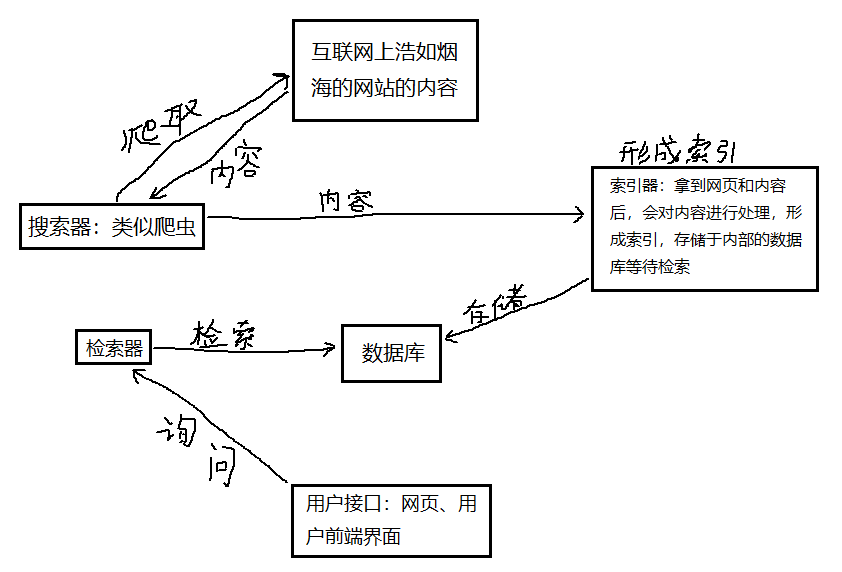

## SearchEngineBase基类
SearchEngineBase继承自object类。SearchEngineBase是不同算法引擎的基类，换句话说，会被各种算法引擎类继承。每一个引擎都应该实现process_corpus()和search()两个方法，它们的对应关系如下：process_corpus()——索引器、search()——检索器。main()函数提供搜索器和用户接口。\
这里需要提一下object类，object是Python中最基本的类，一切类都是基于object，在**Python2.X**中是需要显式继承的，否则自定义的类只有__doc__和__module__两种继承来的方法，显式继承后，就会拥有object的全部方法；在**Python3.X**中，无论是否显式继承object类，都会继承object的所有方法。

In [1]:
class SearchEngineBase(object):
    def __init__(self):
        pass
    
    def add_corpus(self, file_path):
        with open(file_path, 'r') as fin:
            text = fin.read()
        self.process_corpus(file_path, text)
    
    # 索引器
    def process_corpus(self, id, text):
        raise Exception('process_corpus not implemented.')
    
    # 检索器
    def search(self, query):
        raise Exception('search not implemented.')

def main(search_engine):
    # 这个for循环就是在模拟搜索器爬取互联网上网站的内容
    for file_path in ['1.txt', '2.txt', '3.txt', '4.txt', '5.txt']:
        search_engine.add_corpus(file_path)
        
    while True:
        # input()为用户接口
        query = input()
        if query == 'quit':
            break
        results = search_engine.search(query)
        print('found {} result(s):'.format(len(results)))
        for result in results:
            print(result)

## SimpleEngnie子类
SimpleEngnie继承自SearchEngineBase，实现了process_corpus和search接口，继承了add_corpus()方法。

In [2]:
class SimpleEngine(SearchEngineBase):
    def __init__(self):
        super(SimpleEngine,self).__init__()
        self.__id_to_texts = {}
        
    def process_corpus(self, id, text):
        self.__id_to_texts[id] = text
        
    def search(self, query):
        results = []
        for id, text in self.__id_to_texts.items():
            if query in text:
                results.append(id)
        return results

In [3]:
search_engnie = SimpleEngine()
main(search_engnie)

quit


## BOWEngine子类
不难发现SimpleEngnie类的方法时空效率都很低，比如索引器几乎没有任何操作，只是简单的将文件路径与文件内容存入字典，这会占用大量空间；检索器要遍历所有文章的全部内容，这会占用大量时间。\
而且，query只能是一段连续的单词，如果想要搜索多个单词且不连续，SimpleSearch就无能为力了。
### Bag of Words模型
如何优化SimpleSearch呢？\
可以将文章的内容看做是一个一个的单词，将单词放入数据结构set中，这样可以节省大量空间；根据齐夫定律，一个单词出现的频率与它在频率表里的排名成反比，这就可以节省大量时间。

In [4]:
import re

class BOWEngine(SearchEngineBase):
    def __init__(self):
        super(BOWEngine, self).__init__()
        self.__id_to_words = {}
        
    def process_corpus(self, id, text):
        self.__id_to_words[id] = self.parse_text_to_words(text)
        
    def search(self, query):
        query_words = self.parse_text_to_words(query)
        results = []
        for id, words in self.__id_to_words.items():
            if self.query_match(query_words, words):
                results.append(id)
        return results
    
    @staticmethod
    def parse_text_to_words(text):
        # 使用正则表达式去除标点符号和换行符
        text = re.sub(r'[^\w]', ' ', text)
        # 转为小写
        text = text.lower()
        # 生成所有单词的列表
        word_list = text.split(' ')
        # 去除空白单词
        word_list = filter(None, word_list)
        # 返回单词的 set
        return set(word_list)
    
    @staticmethod
    def query_match(query_words, words):
        for query_word in query_words:
            if query_word not in words:
                return False
        return True

可以看到，parse_text_to_words和query_match这两个函数都是没有状态的，它们不涉及对象的私有变量（没有 self 作为参数），相同的输入能够得到完全相同的输出结果。因此设置为静态，可以方便其他的类来使用。

In [5]:
search_engine = BOWEngine()
main(search_engine)

quit


## 更进一步优化——Inverted Index
BOWEngine仍有不足，它虽然不用遍历文件内容已经比SimpleEngine节省了大量时间，但也要遍历所有文件的ID，互联网上是有上亿个页面的，每次全部遍历仍是很大的时间开销。\
再者，词袋模型并不考虑单词间的顺序，但有些人希望单词按顺序出现后者希望query的单词在文中离得近一些，这种需求下词袋模型是无法解决的。
### Inverted Index
如何跟进一步优化呢？\
Inverted Index意为倒序索引，是搜索引擎中的著名方法。所谓倒序就是将id: words倒过来，变为words: id。这样，在检索时只要遍历query_words看一下id重复的即可，无需遍历所有id。

In [6]:
import re

class BOWInvertedIndexEngine(SearchEngineBase):
    def __init__(self):
        super(BOWInvertedIndexEngine, self).__init__()
        self.inverted_index = {}
        
    def process_corpus(self, id, text):
        words = self.parse_text_to_words(text)
        for word in words:
            if word not in self.inverted_index:
                self.inverted_index[word] = []
            self.inverted_index[word].append(id)
            
    def search(self, query):
        query_words = list(self.parse_text_to_words(query))
        query_words_index = []
        for query_word in query_words:
            query_words_index.append(0)
        # 如果某一个查询单词的倒序索引为空，我们就立刻返回 
        for query_word in query_words: 
            if query_word not in self.inverted_index: 
                return [] 
        
        result = []             
        while True: 
            # 首先，获得当前状态下所有倒序索引的 index 
            current_ids = [] 
            for idx, query_word in enumerate(query_words): 
                current_index = query_words_index[idx] 
                current_inverted_list = self.inverted_index[query_word] 
                # 已经遍历到了某一个倒序索引的末尾，结束 search 
                if current_index >= len(current_inverted_list): 
                    return result 
                current_ids.append(current_inverted_list[current_index]) 
            
            # 然后，如果 current_ids 的所有元素都一样，那么表明这个单词在这个元素对应的文档中都出现了 
            if all(x == current_ids[0] for x in current_ids): 
                result.append(current_ids[0]) 
                query_words_index = [x + 1 for x in query_words_index] 
                continue 
                
            # 如果不是，我们就把最小的元素加一
            min_val = min(current_ids)            
            min_val_pos = current_ids.index(min_val)            
            query_words_index[min_val_pos] += 1
            
    @staticmethod 
    def parse_text_to_words(text): 
        # 使用正则表达式去除标点符号和换行符 
        text = re.sub(r'[^\w ]', ' ', text) 
        # 转为小写 
        text = text.lower() 
        # 生成所有单词的列表 
        word_list = text.split(' ') 
        # 去除空白单词 
        word_list = filter(None, word_list) 
        # 返回单词的 set 
        return set(word_list)

In [7]:
search_engine = BOWInvertedIndexEngine()
main(search_engine)

quit


## 面向对象总结
通过前面三个子类的实现可以发现，无论采用什么算法模型，都只需要对__init__()、process_corpus()和search()进行修改。这就是面向对象编程中将算法复杂性隔离开来，而保留接口和其他代码不变的思想。这其实也是大公司里团队协作的一种方式，**在合理的分层设计后，每一层的逻辑只需要处理好分内的事情即可**。

## 多重继承
假设搜索引擎上线后，拥有很高的访问量。但是服务90%以上的流量都是大量的重复搜索，如果可以给服务器加上缓存就可以有效的节省流量缓解服务器的压力。
### LRU
LRU是一种很经典的缓存，它符合自然界的局部性原理，可以保留最近使用过的对象，而逐渐淘汰掉很久没有被用过的对象。

In [9]:
import pylru

class LRUCache(object):
    def __init__(self, size=32):
        self.cache = pylru.lrucache(size)
        
    def has(self, key):
        return key in self.cache
    
    def get(self, key):
        return self.cache[key]
    
    def set(self, key, value):
        self.cache[key] = value
        
class BOWInvertedIndexEngineWithCache(BOWInvertedIndexEngine, LRUCache):
    def __init__(self):
        super(BOWInvertedIndexEngineWithCache, self).__init__()
        LRUCache.__init__(self)
        
    def search(self, query):
        if self.has(query):
            print('cache hit!')
            return self.get(query)
        
        result = super(BOWInvertedIndexEngineWithCache, self).search(query)
        self.set(query, result)
        
        return result

## 多重继承
BOWInvertedIndexEngineWithCache继承自BOWInvertedIndexEngine和LRUCache两个类
### 构造函数
首先看一上述代码的构造函数，多重继承如果有多个构造函数就需要super方法和传统方法同时使用，其中super方法是直接初始化多继承子类的第一个父类，使用super方法要求继承链的最顶层父类必须继承自object类，当然Python3.X不显式指定父类的类都会默然继承object类。
```
super(BOWInvertedIndexEngineWithCache, self).__init__()
LRUCache.__init__(self)
```
### 成员函数
你应该注意，search() 函数被子类 BOWInvertedIndexEngineWithCache 再次重写，但是我还需要调用 BOWInvertedIndexEngine 的 search() 函数，这时该怎么办呢？我们可以强行调用被覆盖的父类的函数。
```

super(BOWInvertedIndexEngineWithCache, self).search(query)
```
综上，这就是多重继承的优势。

In [10]:
search_engine = BOWInvertedIndexEngineWithCache()
main(search_engine)

little
found 1 result(s):
1.txt
quit
